In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.pyplot as mp
import seaborn as sb 
import seaborn as sns 
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# 1. Data Access

In [2]:
def showdata(df_name):
    print('The dimension of dataset=', df_name.shape)
    display(df_name.head(10))

data = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")

data = data.dropna()

showdata(data)

The dimension of dataset= (9998, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
5,6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
7,8,15656148,Obinna,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88,1
10,11,15767821,Bearce,528,France,Male,31.0,6,102016.72,2,0.0,0.0,80181.12,0
11,12,15737173,Andrews,497,Spain,Male,24.0,3,0.00,2,1.0,0.0,76390.01,0
12,13,15632264,Kay,476,France,Female,34.0,10,0.00,2,1.0,0.0,26260.98,0
13,14,15691483,Chin,549,France,Female,25.0,5,0.00,2,0.0,0.0,190857.79,0


People exited: 7960
People stayed: 2038


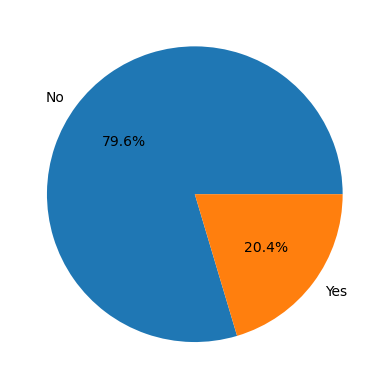

In [3]:
data['Exited'].value_counts()
exit_labels = 'No','Yes'
exit = [data['Exited'].value_counts()[0], data['Exited'].value_counts()[1]]

print("People exited:", exit[0])
print("People stayed:", exit[1])

fig, ax = plt.subplots()
ax.pie(exit, labels=exit_labels, autopct='%1.1f%%')
plt.show()

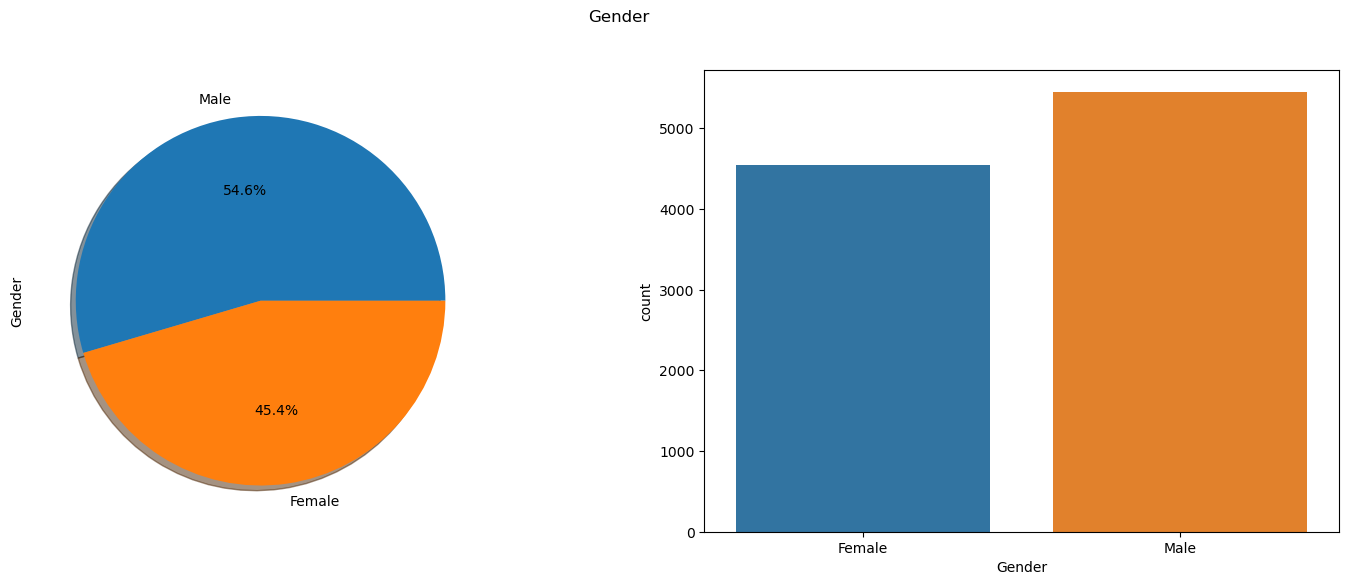

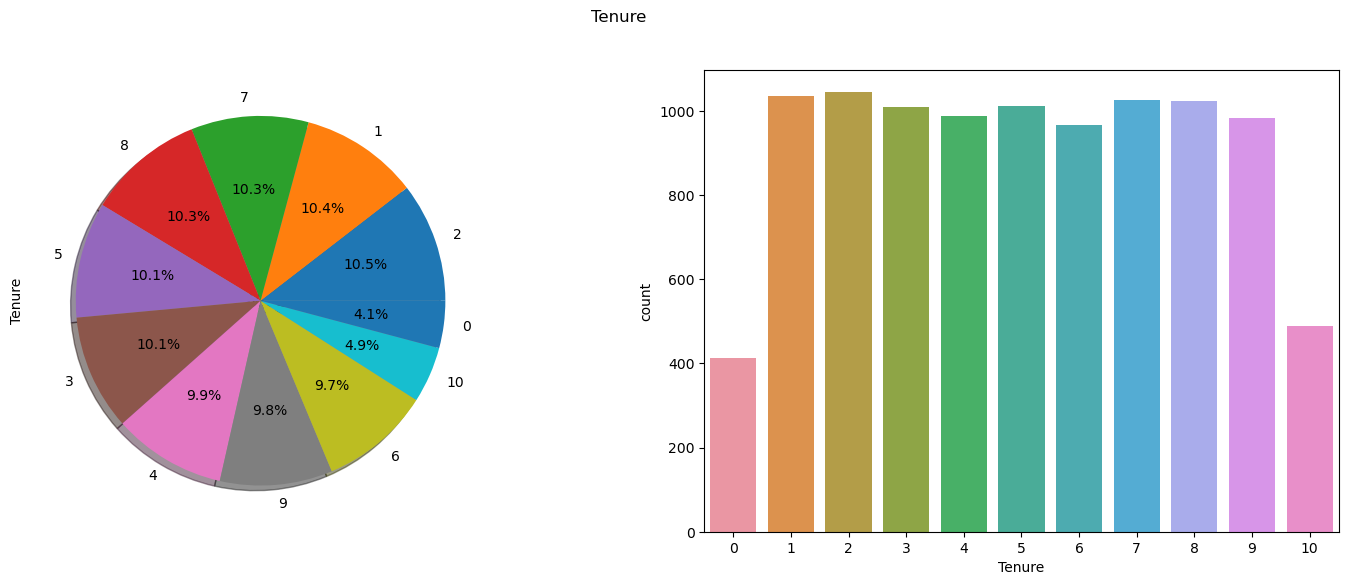

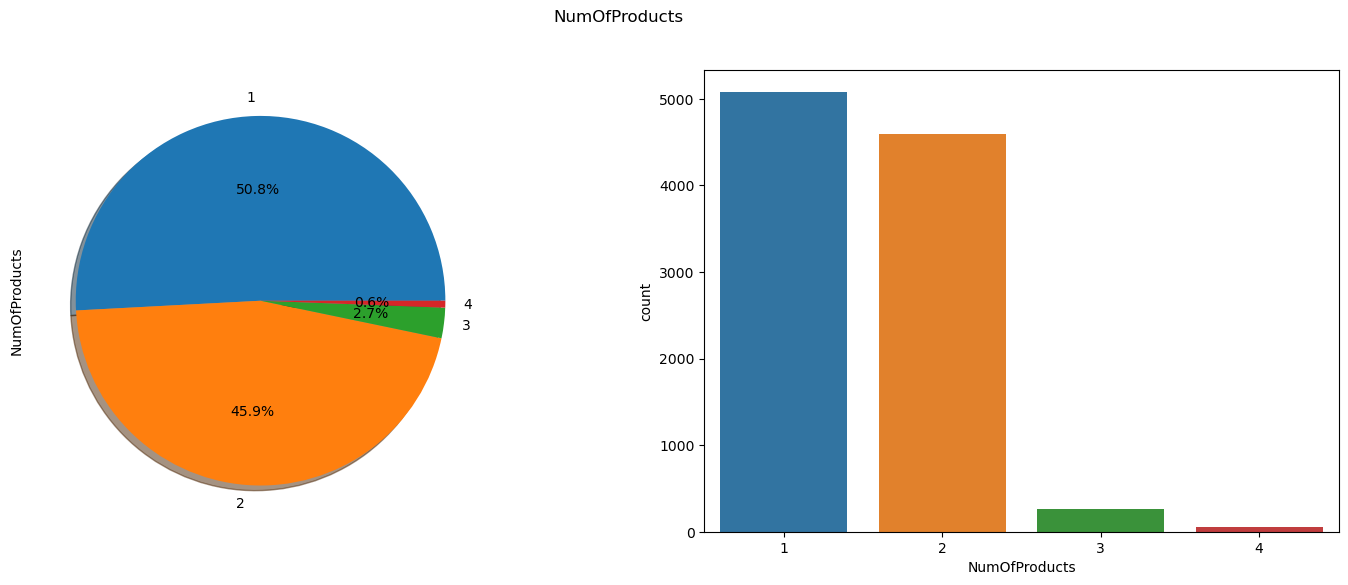

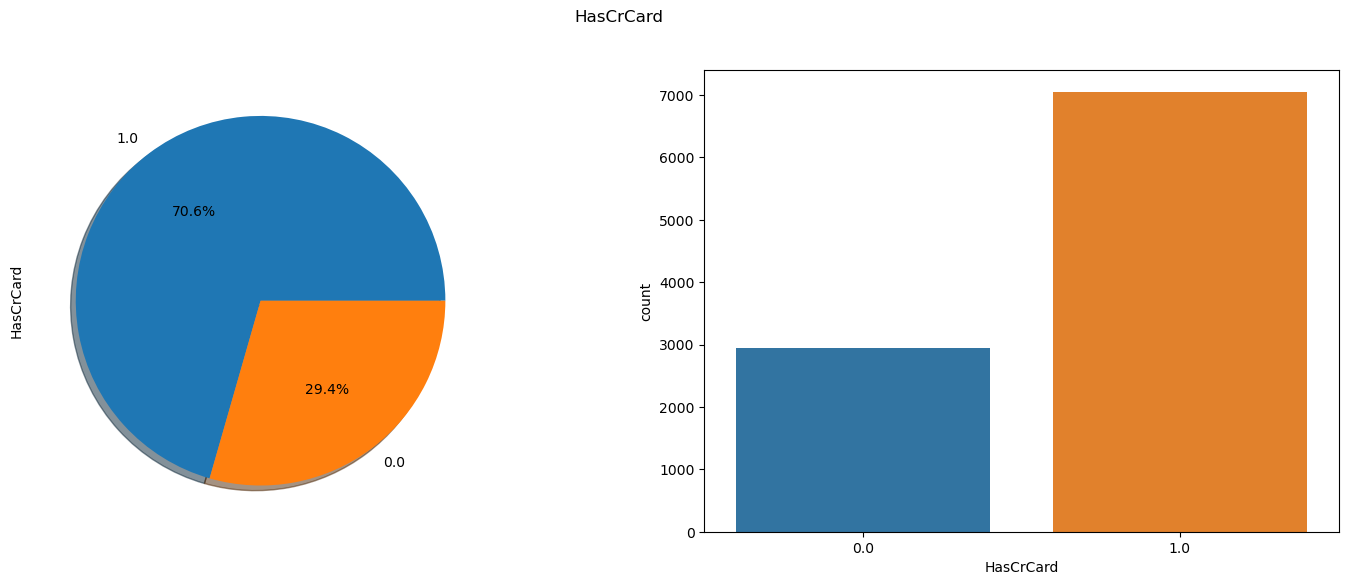

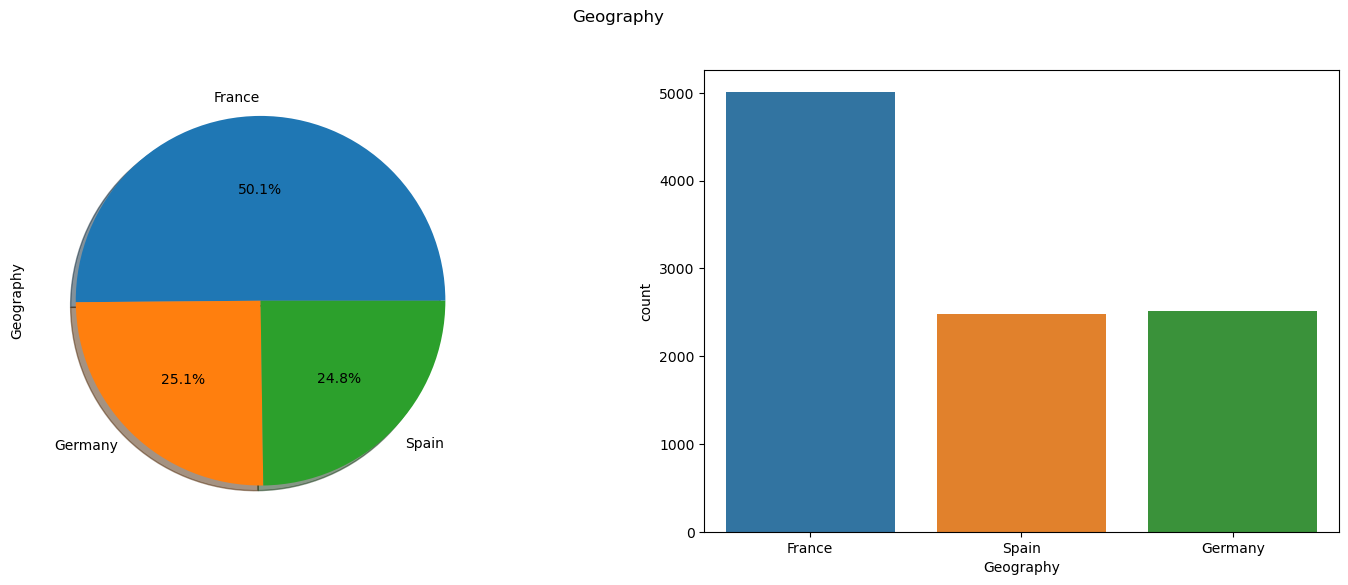

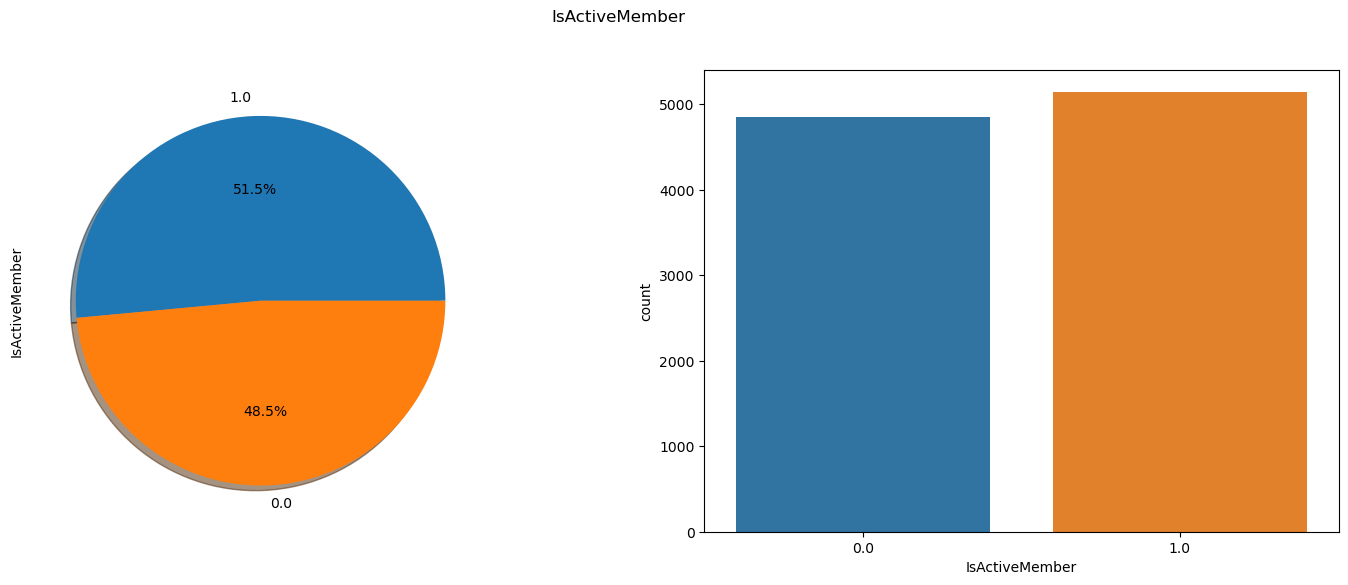

In [4]:
cat_df = data[['Gender','Tenure','NumOfProducts','HasCrCard','Geography','IsActiveMember']]

for col in cat_df:
    f, ax = plt.subplots(1,2,figsize=(18,6))
    cat_df[col].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=True)
    ax[0].set_ylabel(f'{col}')
    sns.countplot(x=col,data=cat_df,ax=ax[1])
    plt.suptitle(f'{col}')
    plt.show()

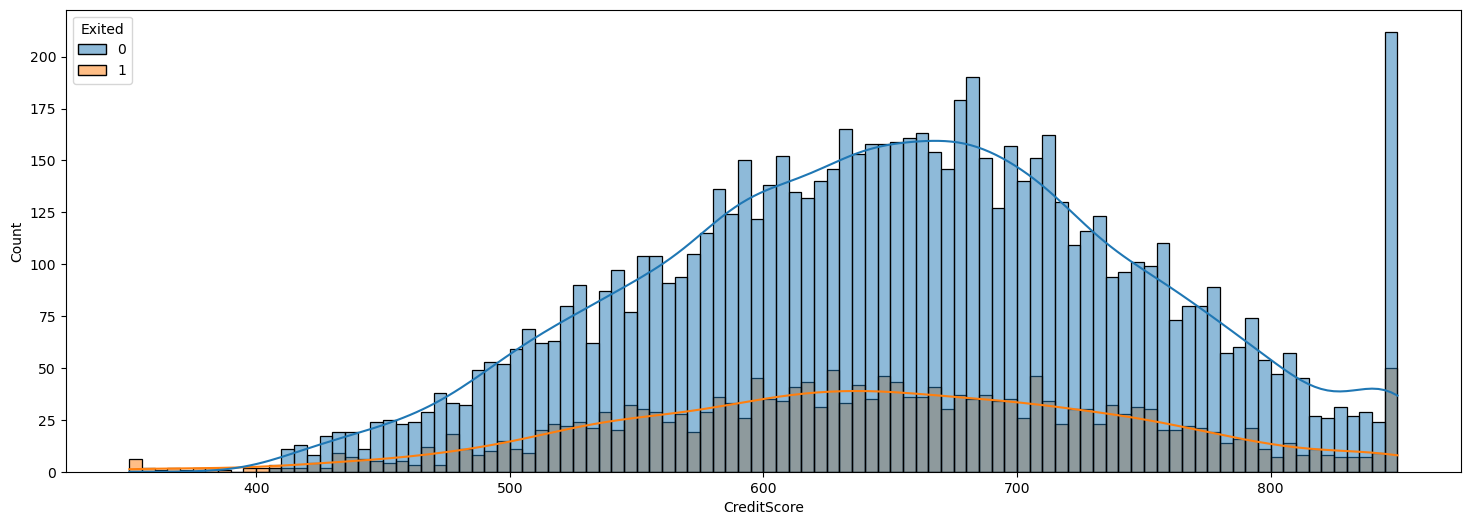

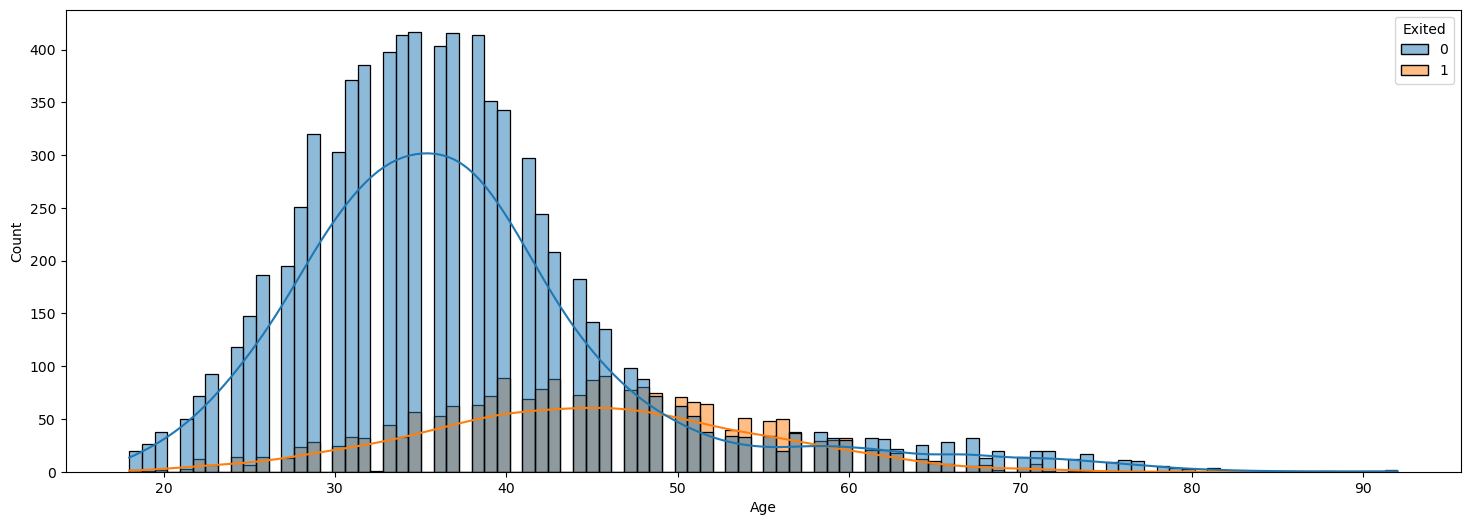

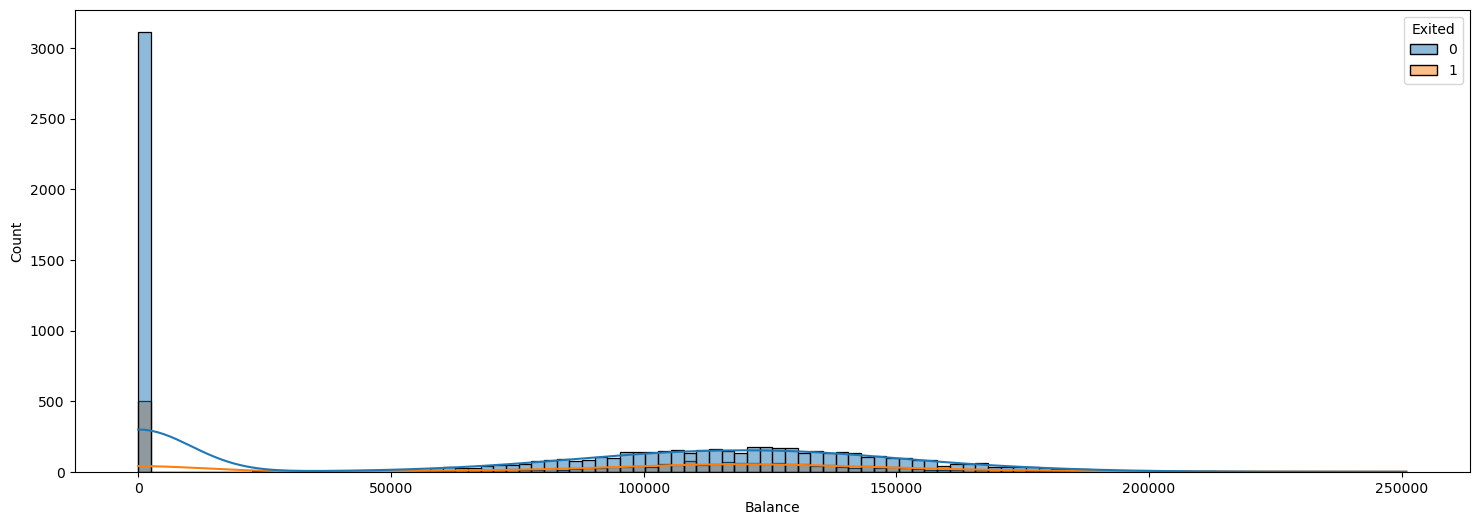

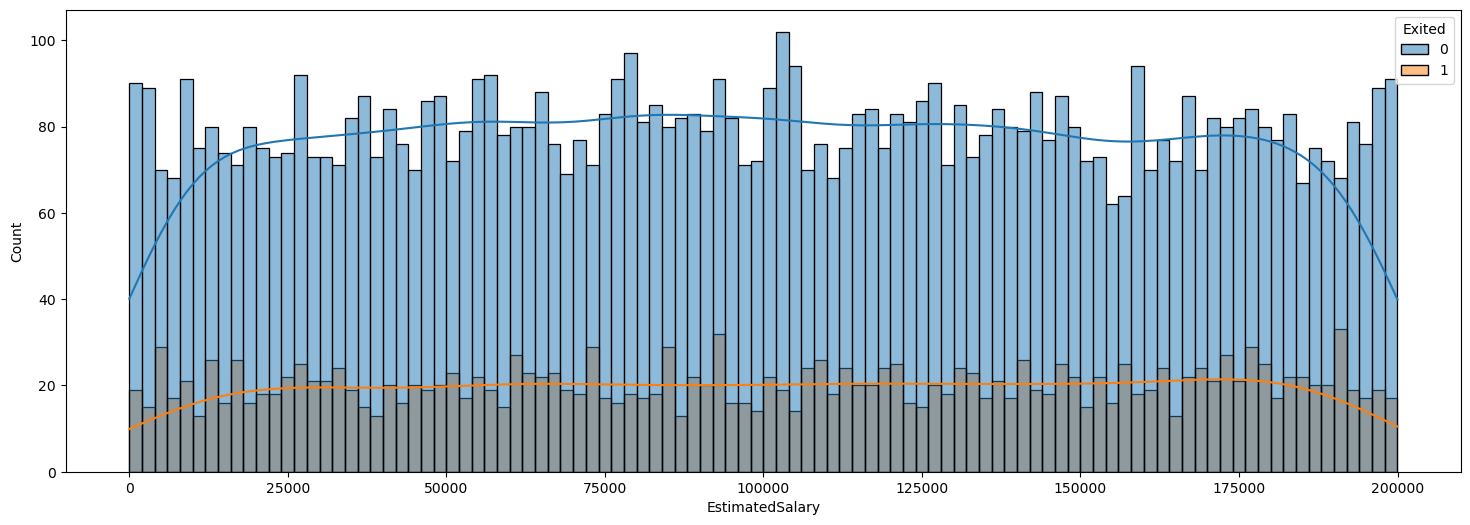

In [5]:
con_df=data[['CreditScore','Age','Balance','EstimatedSalary','Exited']]

for col in con_df:
    if col == 'Exited':
        break
    fig, ax = plt.subplots(figsize=(18,6))
    fig = sns.histplot(data=con_df, x=col, hue='Exited', bins=100,kde=True)
    plt.show()

The dimension of dataset= (9998, 10)


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,0,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,0,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,0,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,645,1,44.0,8,113755.78,2,1.0,0.0,149756.71,1
5,376,0,29.0,4,115046.74,4,1.0,0.0,119346.88,1
6,528,1,31.0,6,102016.72,2,0.0,0.0,80181.12,0
7,497,1,24.0,3,0.00,2,1.0,0.0,76390.01,0
8,476,0,34.0,10,0.00,2,1.0,0.0,26260.98,0
9,549,0,25.0,5,0.00,2,0.0,0.0,190857.79,0


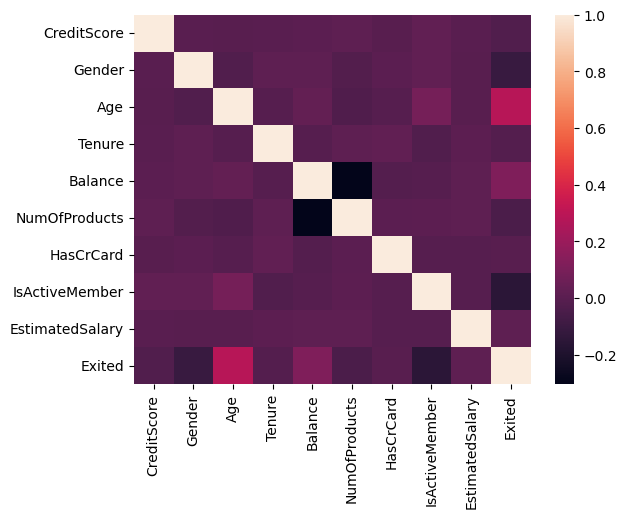

In [6]:
data_corr=data.drop(columns=['RowNumber', 'CustomerId', 'Surname','Geography']).dropna().reset_index()
data_corr=data_corr.drop(columns=['index'])
data_corr['Gender']=np.where(data_corr['Gender']=='Female', 0, 1)

showdata(data_corr)

df_corr = data_corr.copy()


dataplot = sb.heatmap(df_corr.corr())

mp.show()

# 3. Data preparation

In [7]:
data_explainatory=data.drop(columns=['Exited'])
data_response=data['Exited']

explain_train, explain_test, response_train, response_test = train_test_split(
    data_explainatory,
    data_response,
    test_size=0.1,
    random_state=42)


explain_train0=explain_train.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
explain_train = pd.get_dummies(explain_train0, columns=['Geography','Gender','NumOfProducts','HasCrCard','IsActiveMember'])

explain_test0=explain_test.drop(columns=['RowNumber','CustomerId','Surname'], axis=1)
explain_test = pd.get_dummies(explain_test0, columns=['Geography','Gender','NumOfProducts','HasCrCard','IsActiveMember'])

# 4. XGB Classifier

In [8]:
xgb_class = xgb.XGBClassifier(seed=42, objective='binary:logistic',
                              gamma=1.0, learning_rate=0.1, max_depth=5, 
                              reg_lambda=10.0, scale_pos_weight=5, subsample=0.9, 
                              colsample_bytree=0.5)

xgb_class.fit(explain_train, response_train, verbose=True,
              early_stopping_rounds=10, eval_metric='auc',
              eval_set=[(explain_test,response_test)])

[0]	validation_0-auc:0.74369
[1]	validation_0-auc:0.78306
[2]	validation_0-auc:0.83395
[3]	validation_0-auc:0.84654
[4]	validation_0-auc:0.84362
[5]	validation_0-auc:0.85175
[6]	validation_0-auc:0.84958
[7]	validation_0-auc:0.84693
[8]	validation_0-auc:0.84490
[9]	validation_0-auc:0.84111
[10]	validation_0-auc:0.83931
[11]	validation_0-auc:0.83747
[12]	validation_0-auc:0.84584
[13]	validation_0-auc:0.84311
[14]	validation_0-auc:0.84833
[15]	validation_0-auc:0.85134


C:\Users\thp12\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\thp12\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

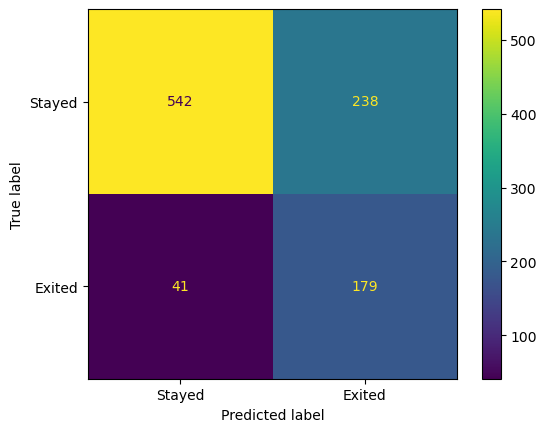

In [9]:
resp_pred_xgb = xgb_class.predict(explain_test)

cm_xgb = confusion_matrix(response_test, resp_pred_xgb, labels=xgb_class.classes_)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Stayed', 'Exited'])
disp_xgb.plot()
plt.show()

Text(0.5, 0, 'Feature importance')

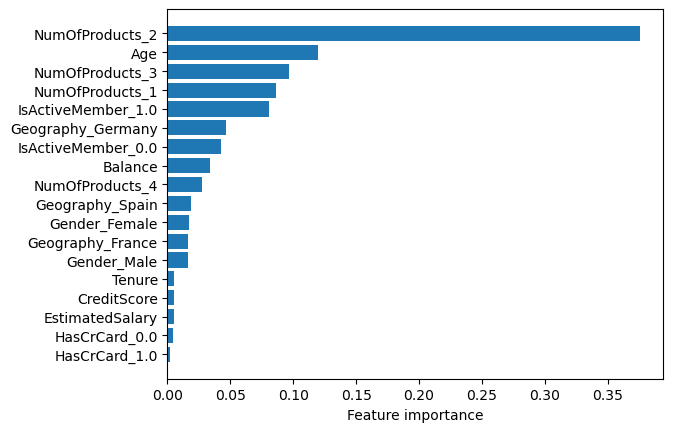

In [10]:
imp_sorted_xgb=xgb_class.feature_importances_.argsort()
plt.barh(explain_test.columns[imp_sorted_xgb], xgb_class.feature_importances_[imp_sorted_xgb])
plt.xlabel("Feature importance")

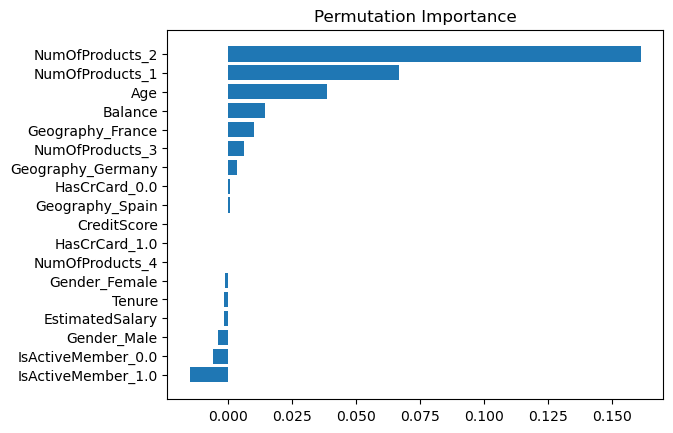

In [11]:
perm_imp_xgb = permutation_importance(xgb_class, np.ascontiguousarray(explain_test), response_test, n_repeats=10, random_state=1066)
perm_imp_sorted_xgb = perm_imp_xgb.importances_mean.argsort()
plt.barh(range(len(perm_imp_sorted_xgb)), perm_imp_xgb.importances_mean[perm_imp_sorted_xgb], align='center')
plt.yticks(range(len(perm_imp_sorted_xgb)), np.array(explain_test.columns)[perm_imp_sorted_xgb])
plt.title('Permutation Importance')
plt.show()

# 5. GBM Classifier

In [12]:
gbm_class = lgb.LGBMClassifier(random_state=42, objective='binary',
                               learning_rate=0.1, max_depth=5,
                               reg_lambda=10.0, scale_pos_weight=5, subsample=0.9,
                               colsample_bytree=0.5, early_stopping_round=10, 
                               verbose=1)


gbm_class.fit(explain_train, response_train,
              eval_metric=['auc','binary_logloss', 'accuracy'],
              eval_set=[(explain_train, response_train), (explain_test,response_test)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1818, number of negative: 7180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 867
[LightGBM] [Info] Number of data points in the train set: 8998, number of used features: 18
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202045 -> initscore=-1.373562
[LightGBM] [Info] Start training from score -1.373562
[LightGBM] [Warning] No further splits with positive gai

LGBMClassifier(colsample_bytree=0.5, early_stopping_round=10, max_depth=5,
               objective='binary', random_state=42, reg_lambda=10.0,
               scale_pos_weight=5, subsample=0.9, verbose=1)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


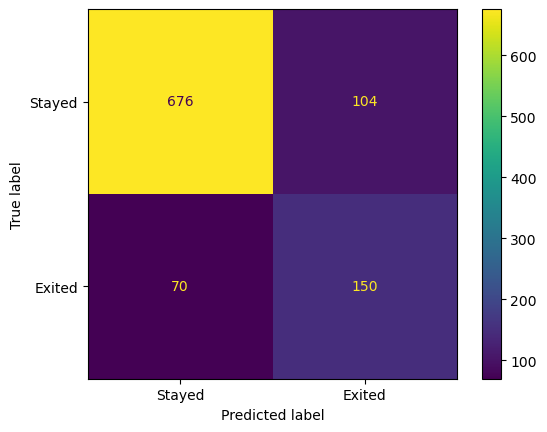

In [13]:
resp_pred_gbm=gbm_class.predict(explain_test)

cm_gbm = confusion_matrix(response_test, resp_pred_gbm, labels=gbm_class.classes_)

disp_gbm = ConfusionMatrixDisplay(confusion_matrix=cm_gbm, display_labels=['Stayed', 'Exited'])
disp_gbm.plot()
plt.show()

Text(0.5, 0, 'Feature importance')

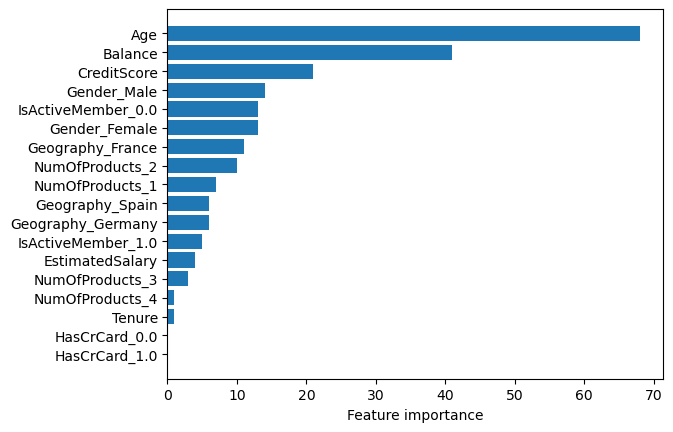

In [14]:
imp_sorted_gbm=gbm_class.feature_importances_.argsort()
plt.barh(explain_test.columns[imp_sorted_gbm], gbm_class.feature_importances_[imp_sorted_gbm])
plt.xlabel("Feature importance")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

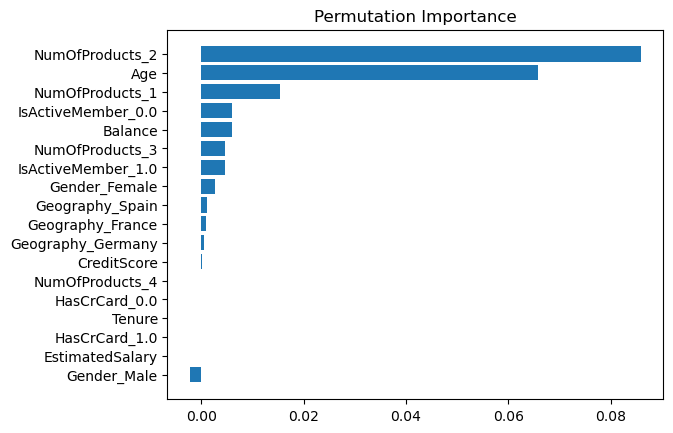

In [15]:
perm_imp_gbm = permutation_importance(gbm_class, np.ascontiguousarray(explain_test), response_test, n_repeats=10, random_state=1066)
perm_imp_sorted_gbm = perm_imp_gbm.importances_mean.argsort()
plt.barh(range(len(perm_imp_sorted_gbm)), perm_imp_gbm.importances_mean[perm_imp_sorted_gbm], align='center')
plt.yticks(range(len(perm_imp_sorted_gbm)), np.array(explain_test.columns)[perm_imp_sorted_gbm])
plt.title('Permutation Importance')
plt.show()

# 6. ROC curves analysis

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


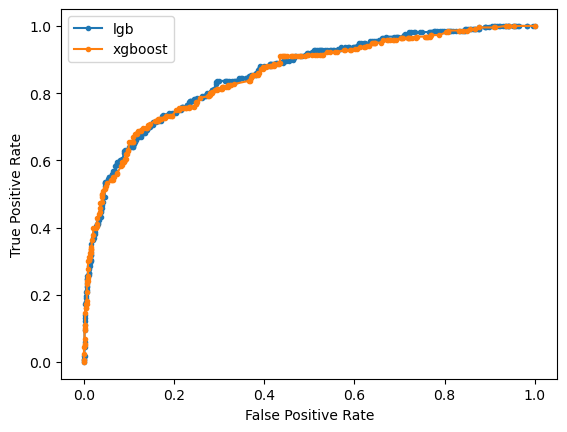

In [16]:
fpr_gbm, tpr_gbm, _ = roc_curve(response_test, gbm_class.predict_proba(explain_test)[:,1])
plt.plot(fpr_gbm, tpr_gbm, marker='.',label='lgb')
fpr_xgb, tpr_xgb, _ = roc_curve(response_test, xgb_class.predict_proba(explain_test)[:,1])
plt.plot(fpr_xgb, tpr_xgb, marker='.',label='xgboost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()